# Getting started with calibrated-explanations - using the WrapCalibratedExplainer class
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
## Classification
Let us illustrate how we may use `calibrated_explanations` to generate explanations from a classifier trained on a dataset from
[www.openml.org](https://www.openml.org), which we first split into a
training and a test set using `train_test_split` from
[sklearn](https://scikit-learn.org), and then further split the
training set into a proper training set and a calibration set:

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml(name="wine", version=7, as_frame=True)

X = dataset.data.values.astype(float)
y = (dataset.target.values == 'True').astype(int)

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2,stratify=y)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)


We now create our wrapper object, using a `RandomForestClassifier` as learner. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from calibrated_explanations import WrapCalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

classifier = WrapCalibratedExplainer(RandomForestClassifier())
display(classifier)

We now fit our model using the proper training set.

In [ ]:
classifier.fit(X_prop_train, y_prop_train)
display(classifier)

Before we can generate explanations, we need to calibrate our model using the calibration set. No discretizer is yet assigned.

In [ ]:
classifier.calibrate(X_cal, y_cal)
display(classifier)

#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. Note that the discretizer is now assigned.

In [ ]:
factual_explanations = classifier.explain_factual(X_test)
display(classifier)

Once we have the explanations, we can plot all of them using `plot_all`. Default, a regular plot, without uncertainty intervals included, is created. To include uncertainty intervals, change the parameter `uncertainty=True`. To plot only a single instance, the `plot_explanation` function can be called, submitting the index of the test instance to plot.

In [ ]:
factual_explanations.plot_all()
factual_explanations.plot_all(uncertainty=True)

factual_explanations.plot_explanation(0, uncertainty=True)

You can also add and remove conjunctive rules.

In [ ]:

factual_explanations.add_conjunctions().plot_all()
factual_explanations.remove_conjunctions().plot_all()

#### Counterfactual Explanations
An alternative to factual rules is to extract counterfactual rules. 
`explain_counterfactual` can be called to get counterfactual rules with an appropriate discretizer automatically assigned. Note that the discretizer has changed. 

In [ ]:
counterfactual_explanations = classifier.explain_counterfactual(X_test)
display(classifier)

Counterfactuals are also visualized using the `plot_all`. Plotting an individual counterfactual explanation is done using `plot_explanation`, submitting the index to plot. Adding or removing conjunctions is done as before. 

In [ ]:
counterfactual_explanations.plot_all()
counterfactual_explanations.add_conjunctions().plot_all()
counterfactual_explanations.remove_conjunctions().plot_all()

counterfactual_explanations.plot_explanation(0)

`calibrated_explanations` supports multiclass which is demonstrated in [demo_multiclass](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_multiclass.ipynb). That notebook also demonstrates how both feature names and target and categorical labels can be added to improve the interpretability. 
## Regression
Extracting explanations for regression is very similar to how it is done for classification. First we load and divide the dataset.   

In [ ]:
dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=42)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

We now create our wrapper object, using a `RandomForestRegressor` as learner. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = WrapCalibratedExplainer(RandomForestRegressor())
display(regressor)

We now fit our model using the proper training set.

In [49]:
regressor.fit(X_prop_train, y_prop_train)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=False)

Before we can generate explanations, we need to calibrate our model using the calibration set. No discretizer is yet assigned.

In [50]:
regressor.calibrate(X_cal, y_cal)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                discretizer=<class 'NoneType'>
	                model=RandomForestRegressor()
	                difficulty_estimator=None)

#### Factual Explanations
Let us explain a test instance using our `WrapCalibratedExplainer` object. The method used to get factual explanations is `explain_factual`. Note that the discretizer is now assigned.

In [51]:
factual_explanations = regressor.explain_factual(X_test)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                discretizer=<class 'calibrated_explanations._discretizers.BinaryDiscretizer'>
	                model=RandomForestRegressor()
	                difficulty_estimator=None)

Regression also offer both regular and uncertainty plots for factual explanations with or without conjunctive rules, in almost exactly the same way as for classification. 

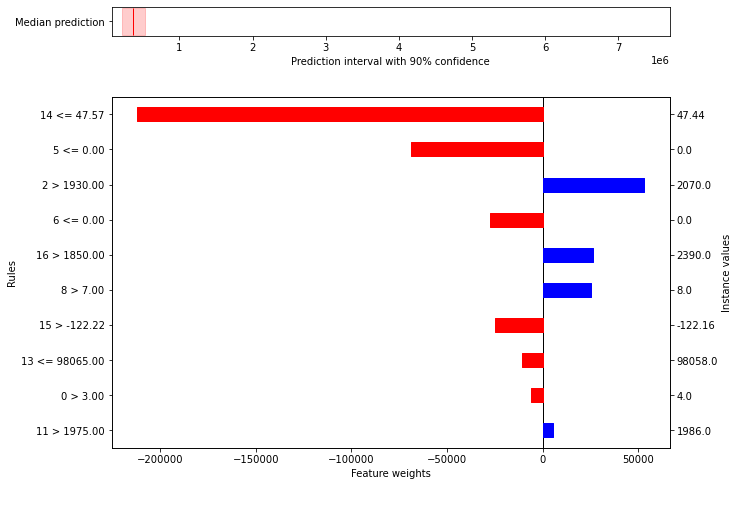

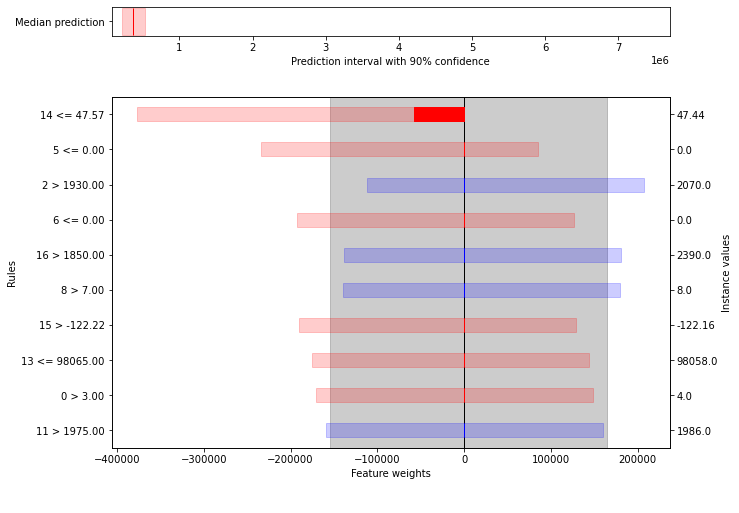

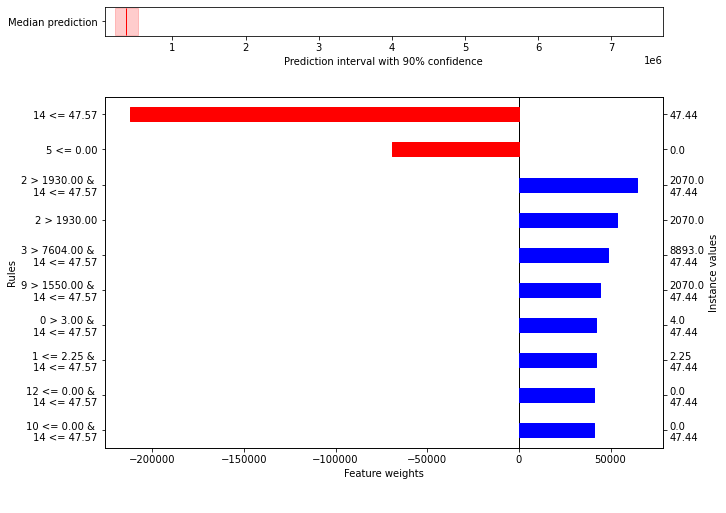

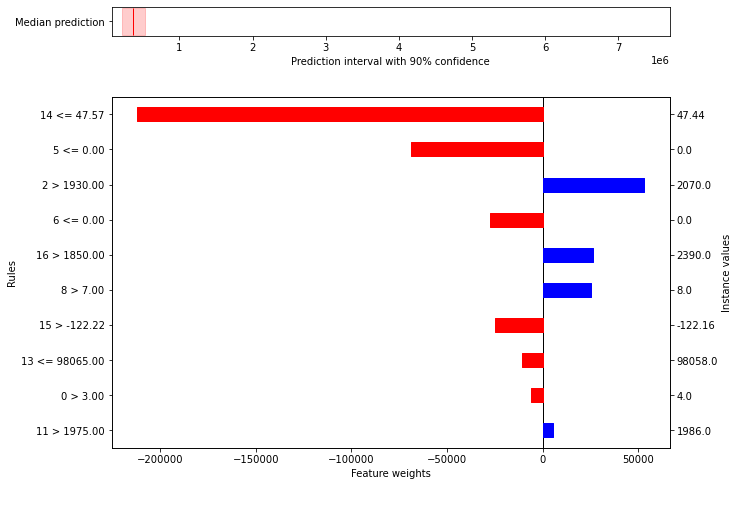

In [52]:
factual_explanations.plot_all()
factual_explanations.plot_all(uncertainty=True)

factual_explanations.add_conjunctions().plot_all()
factual_explanations.remove_conjunctions().plot_all()

#### Counterfactual Explanations
The `explain_counterfactual` will work exactly the same as for classification. Note that the discretizer is now changed. 

In [53]:
counterfactual_explanations = regressor.explain_counterfactual(X_test)
display(regressor)

WrapCalibratedExplainer(learner=RandomForestRegressor(), fitted=True, calibrated=True, explainer=CalibratedExplainer:
	                mode=regression
	                discretizer=<class 'lime.discretize.DecileDiscretizer'>
	                model=RandomForestRegressor()
	                difficulty_estimator=None)

Counterfactual plots work as for classification.

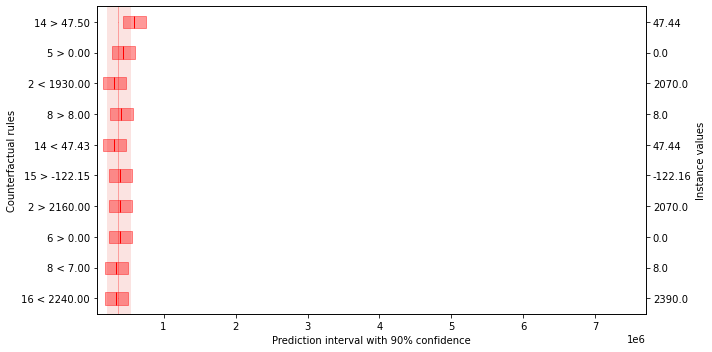

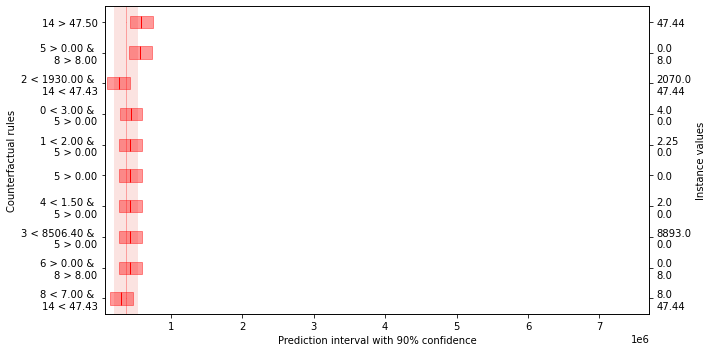

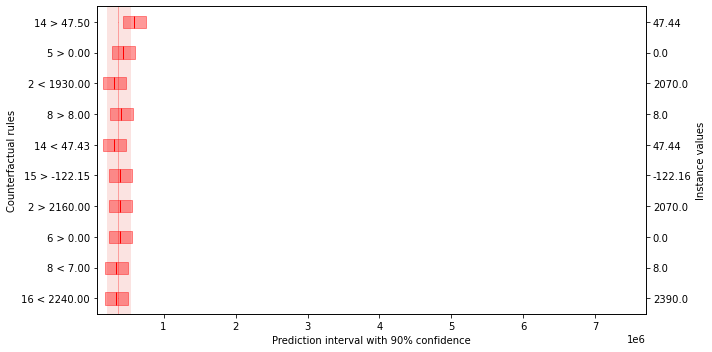

In [54]:

counterfactual_explanations.plot_all()
counterfactual_explanations.add_conjunctions().plot_all()
counterfactual_explanations.remove_conjunctions().plot_all()

Regression offers many more options but to learn more about them, see the [demo_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_regression.ipynb) or the [demo_probabilistic_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_probabilistic_regression.ipynb) notebooks.